In [2]:
import os
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint


In [3]:
import os

base_path = "archive"
results = {}  # vai conter um dicionário para cada subpasta

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    # entra na subpasta com o mesmo nome da pasta
    subfolder_path = os.path.join(folder_path, folder)
    if not os.path.isdir(subfolder_path):
        continue

    folder_dict = {}  # dicionário só dessa subpasta

    for file in os.listdir(subfolder_path):
        if file.endswith(".bmp"):
            prefix = file[:-4]  # remove ".bmp"

            cyt_files = sorted(
                f for f in os.listdir(subfolder_path)
                if f.startswith(prefix + "_cyt") and f.endswith(".dat")
            )
            nuc_files = sorted(
                f for f in os.listdir(subfolder_path)
                if f.startswith(prefix + "_nuc") and f.endswith(".dat")
            )

            key = f"{folder}_{file}"  # nome único
            folder_dict[key] = cyt_files + nuc_files

    results[folder] = folder_dict  # adiciona o dicionário da subpasta

# Exemplo de acesso: results["im_Dyskeratotic"]["im_Dyskeratotic_001.bmp"]


In [4]:
import os

base_path = "archive"

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    subfolder_path = os.path.join(folder_path, folder)
    if not os.path.isdir(subfolder_path):
        continue

    for file in os.listdir(subfolder_path):
        if file.endswith(".dat"):
            dat_path = os.path.join(subfolder_path, file)

            # Lê o conteúdo original
            with open(dat_path, "r") as f:
                content = f.read()

            # Verifica se já tem cabeçalho
            if not content.startswith("x,y"):
                # Adiciona 'x,y' no início + quebra de linha
                with open(dat_path, "w") as f:
                    f.write("x,y\n" + content)

print("✅ Cabeçalho 'x,y' adicionado em todos os .dat que não tinham.")


✅ Cabeçalho 'x,y' adicionado em todos os .dat que não tinham.


In [5]:
print(results["im_Dyskeratotic"]["im_Dyskeratotic_124.bmp"])

['124_cyt01.dat', '124_cyt02.dat', '124_cyt03.dat', '124_cyt04.dat', '124_nuc01.dat', '124_nuc02.dat', '124_nuc03.dat', '124_nuc04.dat']


In [6]:
a = "dsdd.dmp"
print(a[-6:-4])

dd


In [7]:
lista = []

for key in results.keys():
    for subkey in results[key].keys():
        files = results[key][subkey]
        # dicionário para agrupar por número do par (dois caracteres antes de .dat)
        pares_dict = {}
        for f in files:
            num = f[-6:-4]  # pega os dois caracteres antes de ".dat"
            if num not in pares_dict:
                pares_dict[num] = []
            pares_dict[num].append(f)
        
        # agora forma os pares (cyt, nuc)
        for num, group in pares_dict.items():
            cyt_file = next((x for x in group if "_cyt" in x), None)
            nuc_file = next((x for x in group if "_nuc" in x), None)
            if cyt_file and nuc_file:
                lista.append([key, cyt_file, nuc_file])

print(len(lista))

# exemplo de busca
for l in lista:
    if l[1] == "002_cyt02.dat":
        print(l)


4049
['im_Dyskeratotic', '002_cyt02.dat', '002_nuc02.dat']
['im_Superficial-Intermediate', '002_cyt02.dat', '002_nuc02.dat']
['im_Metaplastic', '002_cyt02.dat', '002_nuc02.dat']
['im_Parabasal', '002_cyt02.dat', '002_nuc02.dat']


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

save_dir = "mask"
os.makedirs(save_dir, exist_ok=True)

for l in lista[4000:]:
    img_path = f"archive/{l[0]}/{l[0]}/{l[1][:3]}.bmp"
    cyt = pd.read_csv(f"archive/{l[0]}/{l[0]}/{l[1]}")
    nuc = pd.read_csv(f"archive/{l[0]}/{l[0]}/{l[2]}")

    # lê imagem para pegar dimensões
    img = mpimg.imread(img_path)
    altura, largura = img.shape[:2]

    # cria imagem vazia (preta)
    img_vazia = np.zeros((altura, largura, 3), dtype=np.uint8)

    # cria figura
    fig, ax = plt.subplots()
    ax.imshow(img_vazia)
    ax.axis("off")

    # desenha polígonos
    ax.fill(cyt[cyt.columns[0]], cyt[cyt.columns[1]], color="green", alpha=0.4)
    ax.fill(nuc[nuc.columns[0]], nuc[nuc.columns[1]], color="brown", alpha=0.4)

    # nome do arquivo de saída
    print(l)
    out_name = f"{l[0]}{l[1][:3]}_{l[1][-6:-4]}_mask.png"
    out_path = os.path.join(save_dir, out_name)

    # salva imagem sem bordas extras e fundo transparente
    plt.savefig(out_path, bbox_inches="tight", pad_inches=0, transparent=True)
    plt.close(fig)

    print(cyt)

    if len(cyt[cyt.columns[0]]) < 3:
        print("Célula com menos de 3 pontos, pulando o restante.")
        break


    print(f"Máscara salva em: {out_path}")
        

['im_Parabasal', '001_cyt02.dat', '001_nuc02.dat']
      x      y
0   531  579.5
1   545  581.5
2   561  582.5
3   581  595.5
4   594  607.5
5   605  623.5
6   617  637.5
7   634  644.5
8   644  651.5
9   644  667.5
10  639  684.5
11  639  691.5
12  643  712.5
13  639  726.5
14  623  731.5
15  609  736.5
16  597  745.5
17  585  755.5
18  569  764.5
19  556  770.5
20  542  776.5
21  529  780.5
22  510  783.5
23  508  784.5
24  493  786.5
25  474  790.5
26  460  791.5
27  450  781.5
28  442  763.5
29  432  735.5
30  428  717.5
31  425  694.5
32  426  683.5
33  434  660.5
34  438  645.5
35  443  628.5
36  448  618.5
37  461  600.5
38  469  586.5
39  479  577.5
40  494  577.5
41  517  581.5
42  531  579.5
Máscara salva em: mask/im_Parabasal001_02_mask.png
['im_Parabasal', '001_cyt03.dat', '001_nuc03.dat']
       x    y
0   1474  469
1   1494  478
2   1517  493
3   1530  505
4   1539  518
5   1546  537
6   1551  544
7   1558  558
8   1562  571
9   1566  586
10  1568  602
11  1564  616
12  1

In [ ]:
percorrer mask

para todo arquivo com nome[:-12] igual juntar as imagens em uma so 

In [15]:
import os
from PIL import Image
import numpy as np
from collections import defaultdict

mask_dir = "mask"
output_dir = "mask_combined"
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

groups = defaultdict(list)
for f in files:
    prefix = f[:-12]  # ajuste conforme padrão
    groups[prefix].append(f)

for prefix, flist in groups.items():
    combined = None
    for i, f in enumerate(flist):
        path = os.path.join(mask_dir, f)
        img = Image.open(path).convert("RGB")
        img_arr = np.array(img)

        if combined is None:
            combined = img_arr.copy()
        else:
            # redimensiona para mesmo tamanho da primeira imagem
            img_arr = np.array(img.resize((combined.shape[1], combined.shape[0]), resample=Image.NEAREST))

            # sobrescreve pixels que não são pretos
            mask = np.any(img_arr != 0, axis=-1)
            combined[mask] = img_arr[mask]

    out_path = os.path.join(output_dir, f"{prefix}_combined.png")
    Image.fromarray(combined).save(out_path)
    print(f"Salvo: {out_path}")


Salvo: mask_combined/im_Koilocytotic123_combined.png
Salvo: mask_combined/im_Dyskeratotic083_combined.png
Salvo: mask_combined/im_Dyskeratotic093_combined.png
Salvo: mask_combined/im_Parabasal025_combined.png
Salvo: mask_combined/im_Dyskeratotic217_combined.png
Salvo: mask_combined/im_Parabasal028_combined.png
Salvo: mask_combined/im_Parabasal100_combined.png
Salvo: mask_combined/im_Koilocytotic076_combined.png
Salvo: mask_combined/im_Dyskeratotic198_combined.png
Salvo: mask_combined/im_Koilocytotic105_combined.png
Salvo: mask_combined/im_Koilocytotic113_combined.png
Salvo: mask_combined/im_Dyskeratotic066_combined.png
Salvo: mask_combined/im_Koilocytotic233_combined.png
Salvo: mask_combined/im_Parabasal098_combined.png
Salvo: mask_combined/im_Parabasal053_combined.png
Salvo: mask_combined/im_Dyskeratotic011_combined.png
Salvo: mask_combined/im_Dyskeratotic026_combined.png
Salvo: mask_combined/im_Koilocytotic042_combined.png
Salvo: mask_combined/im_Dyskeratotic088_combined.png
Salvo: m

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Ajuste de tamanho para concatenar
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


# ----- CABEÇA FINAL: convolução 1x1 para gerar classes -----
class OutConv(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# ----- U-NET COMPLETA -----
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    

In [25]:
class litUnet(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(n_channels=3, n_classes=1)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, masks)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, masks)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, masks)
        self.log('test_loss', loss)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, _ = batch
        outputs = self(images)
        return torch.sigmoid(outputs)
    

In [31]:
import os
import pandas as pd

base_img_dir = "archive"
mask_dir = "mask_combined"

Cells_Data = pd.DataFrame(columns=["img", "mask"])

for namedir in os.listdir(base_img_dir):
    namedir_path = os.path.join(base_img_dir, namedir)
    subdir_path = os.path.join(namedir_path, namedir)
    
    if not os.path.isdir(subdir_path):
        continue

    for f in os.listdir(subdir_path):
        if f.endswith(".bmp"):
            img_path = os.path.join(subdir_path, f)

            # pega os 3 primeiros caracteres do nome do bmp
            num = f[:3]

            # máscara está diretamente na pasta mask_combined
            mask_name = f"{namedir}{num}_combined.png"
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):
                Cells_Data = pd.concat([Cells_Data, pd.DataFrame({"img":[img_path], "mask":[mask_path]})], ignore_index=True)
            else:
                print(f"⚠️ Máscara não encontrada: {mask_path}")

print("✅ DataFrame criado!")
print(Cells_Data.head())


✅ DataFrame criado!
                                               img  \
0  archive/im_Dyskeratotic/im_Dyskeratotic/118.bmp   
1  archive/im_Dyskeratotic/im_Dyskeratotic/117.bmp   
2  archive/im_Dyskeratotic/im_Dyskeratotic/134.bmp   
3  archive/im_Dyskeratotic/im_Dyskeratotic/214.bmp   
4  archive/im_Dyskeratotic/im_Dyskeratotic/175.bmp   

                                            mask  
0  mask_combined/im_Dyskeratotic118_combined.png  
1  mask_combined/im_Dyskeratotic117_combined.png  
2  mask_combined/im_Dyskeratotic134_combined.png  
3  mask_combined/im_Dyskeratotic214_combined.png  
4  mask_combined/im_Dyskeratotic175_combined.png  


In [ ]:
from torch.utils.data import Dataset, random_split
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor

class Cell_Data(Dataset):
    def __init__(self, df, transform=None):
        """
        df: DataFrame com colunas ["img", "mask"]
        """
        self.img_files = df["img"].tolist()
        self.mask_files = df["mask"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# ---- transforms ----
transforms = Compose([
    Resize((128, 128)),
    ToTensor()
])

# ---- cria dataset ----
full_dataset = Cell_Data(Cells_Data, transform=transforms)

# ---- split train/test ----
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 772, Test samples: 194


In [33]:
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size_final, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [34]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
model = litUnet()

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='unet-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback], accelerator='auto', precision=16, log_every_n_steps=10)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/al.igor.alves/Modelos/Cervical_/.venv/lib

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s, v_num=8]


In [37]:
model = litUnet.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.026995325461030006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.026995325461030006}]

In [ ]:
model = litUnet()
trainer.predict(model, dataloaders=test_loader)
predict_loader = DataLoader(test_dataset, batch_size=1)
predictions = trainer.predict(model, dataloaders=predict_loader)
predictions

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 194/194 [00:02<00:00, 66.80it/s]


[tensor([[[[0.5210, 0.5200, 0.5190,  ..., 0.5215, 0.5210, 0.5215],
           [0.5220, 0.5220, 0.5195,  ..., 0.5195, 0.5200, 0.5215],
           [0.5225, 0.5210, 0.5171,  ..., 0.5190, 0.5195, 0.5210],
           ...,
           [0.5229, 0.5215, 0.5181,  ..., 0.5166, 0.5176, 0.5186],
           [0.5225, 0.5215, 0.5195,  ..., 0.5176, 0.5176, 0.5195],
           [0.5205, 0.5190, 0.5166,  ..., 0.5166, 0.5166, 0.5195]]]],
        dtype=torch.float16),
 tensor([[[[0.5215, 0.5210, 0.5210,  ..., 0.5205, 0.5205, 0.5215],
           [0.5220, 0.5210, 0.5210,  ..., 0.5195, 0.5195, 0.5210],
           [0.5220, 0.5210, 0.5205,  ..., 0.5186, 0.5190, 0.5205],
           ...,
           [0.5225, 0.5210, 0.5190,  ..., 0.5186, 0.5190, 0.5200],
           [0.5225, 0.5215, 0.5205,  ..., 0.5190, 0.5186, 0.5205],
           [0.5210, 0.5195, 0.5176,  ..., 0.5176, 0.5181, 0.5200]]]],
        dtype=torch.float16),
 tensor([[[[0.5215, 0.5215, 0.5215,  ..., 0.5205, 0.5205, 0.5215],
           [0.5215, 0.5210, 0.5

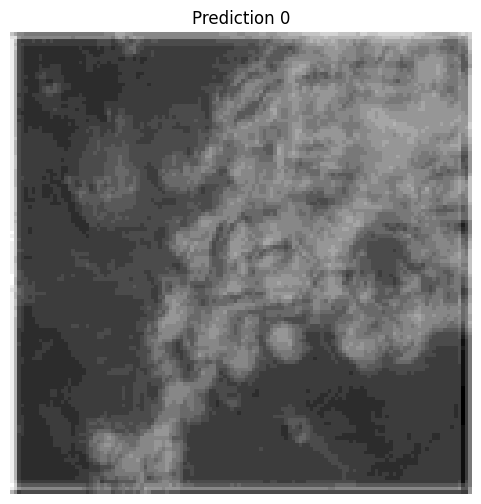

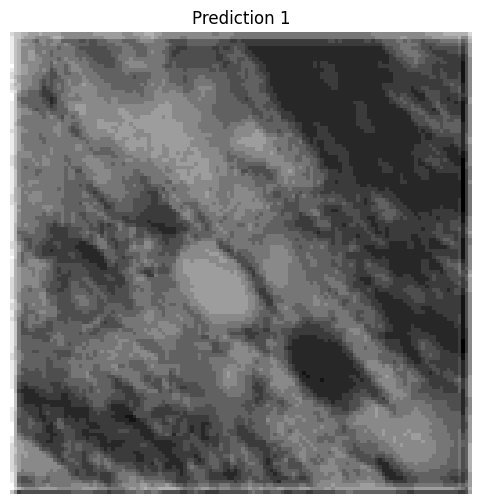

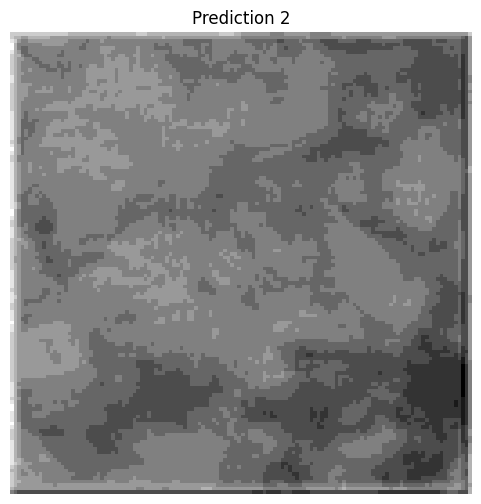

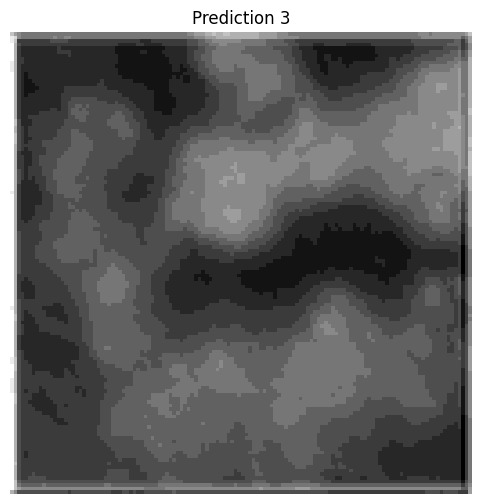

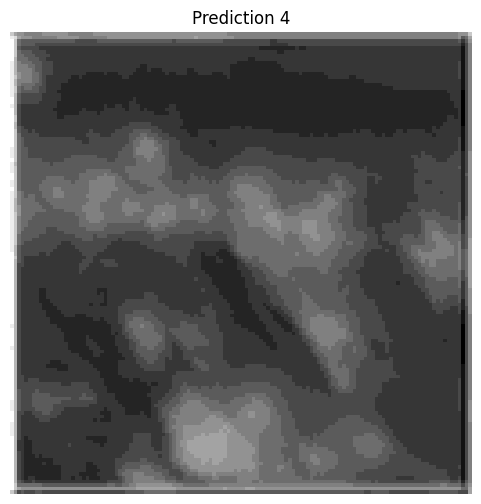

In [40]:
import matplotlib.pyplot as plt
import torch

# pega algumas previsões para visualizar
num_to_show = 5  # quantidade de imagens que quer mostrar
for i in range(num_to_show):
    pred = predictions[i]  # pode ser uma lista, depende do Lightning
    if isinstance(pred, list):  # Lightning às vezes retorna lista
        pred = pred[0]

    # converte de tensor para numpy
    pred_np = pred.squeeze().cpu().numpy()  # remove channel se tiver 1

    plt.figure(figsize=(6, 6))
    plt.imshow(pred_np, cmap='gray')
    plt.title(f"Prediction {i}")
    plt.axis('off')
    plt.show()


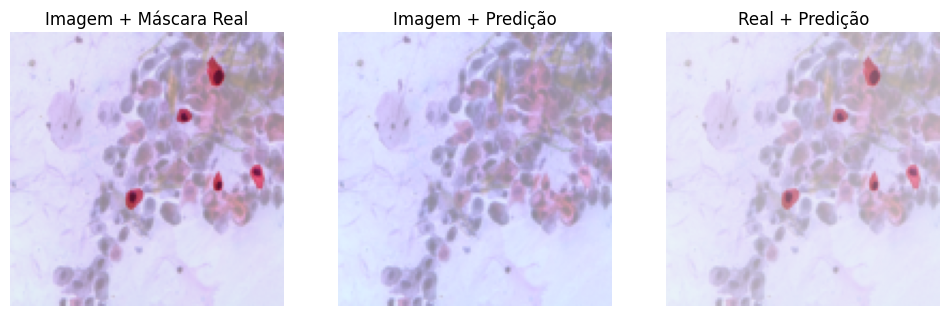

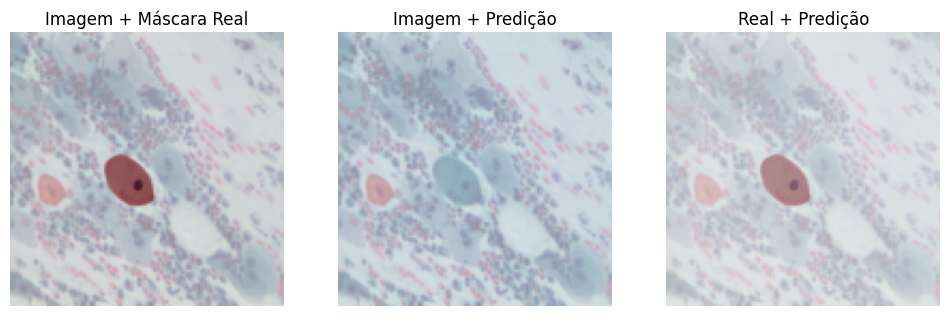

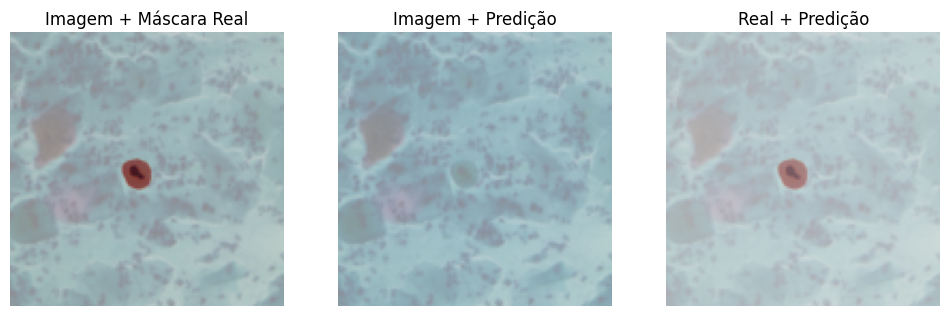

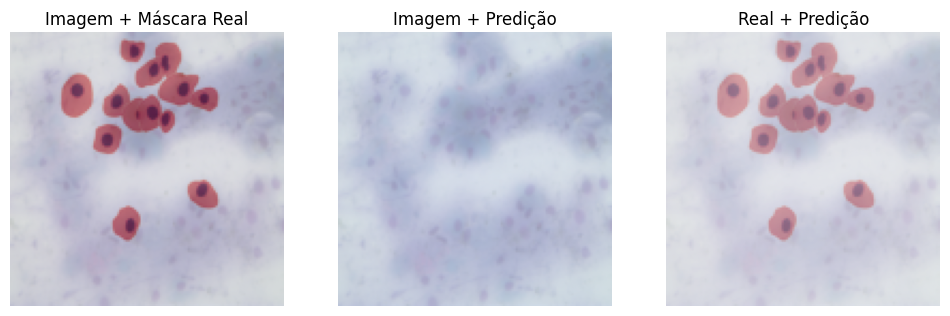

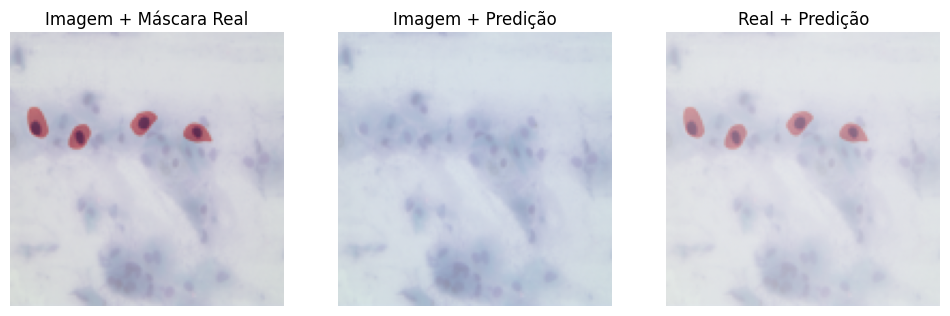

In [41]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# pega algumas amostras do test_dataset para visualização
num_to_show = 5

for i in range(num_to_show):
    # imagem original e máscara real
    img_tensor, mask_tensor = test_dataset[i]
    
    # converte para numpy
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    mask_np = mask_tensor.squeeze().cpu().numpy()        # remove channel se tiver 1

    # previsão
    pred = predictions[i]
    if isinstance(pred, list):
        pred = pred[0]
    pred_np = torch.sigmoid(pred).squeeze().cpu().numpy()  # aplica sigmoid se saída não binária

    # binariza máscara prevista (opcional)
    pred_bin = (pred_np > 0.5).astype(np.float32)

    # visualização lado a lado
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.imshow(mask_np, cmap='Reds', alpha=0.5)  # máscara real em vermelho semi-transparente
    plt.title("Imagem + Máscara Real")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_np)
    plt.imshow(pred_bin, cmap='Blues', alpha=0.5)  # máscara prevista em azul semi-transparente
    plt.title("Imagem + Predição")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(mask_np, cmap='Reds', alpha=0.5)
    plt.imshow(pred_bin, cmap='Blues', alpha=0.3)  # sobreposição real + previsão
    plt.title("Real + Predição")
    plt.axis('off')

    plt.show()
